# Preamble

## Analysis resources

- [Sean Davis single-cell-awesome](https://github.com/seandavi/awesome-single-cell)
- [Martin Hemberg's Single Cell Book](https://hemberg-lab.github.io/scRNA.seq.course/index.html)
- [Aaron Lun's Single Cell Workflow](http://bioconductor.org/help/workflows/simpleSingleCell/)
- [Cold Spring Harbor Lab's Single Cell Bioinformatics Workshop](https://github.com/YeoLab/single-cell-bioinformatics/)
- [Seurat tutorials](https://satijalab.org/seurat/get_started.html)
- [Scanpy tutorials](https://scanpy.readthedocs.io/en/latest/tutorials.html)

## Analysis package options

### Two major players, split along your favorite programming language

- [Seurat](https://satijalab.org/seurat/) (R-based)
- [Scanpy](https://scanpy.readthedocs.io/en/latest/) (Python-based)

There are dozens of packages that perform one task well and can usually be called from the frameworks above.

### We will be using the Scanpy ecosystem today, but all these steps can be reproduced using the equivalent functions in Seurat

## Dataset details

- Provided by 10x Genomics
- ~5,000 nuclei extracted from the PFC and hippocampus
- Data download [here](https://www.10xgenomics.com/resources/datasets/5k-adult-mouse-brain-nuclei-isolated-with-chromium-nuclei-isolation-kit-3-1-standard)

## Loading in necessary packages

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["figure.dpi"] = 200

from pathlib import Path

import warnings
warnings.filterwarnings("ignore")

## Loading in data
We can either read in the 3 files that constitute a sparse matrix (`matrix.mtx`, `features.tsv`, `barcodes.tsv`) or read the consolidated `.h5` file.  Let's go with the latter.

In [2]:
data_root = Path(".") / ".." / "data" / "scrnaseq" / "outs"

In [3]:
adata = sc.read_10x_h5(data_root / "5k_mouse_brain_CNIK_3pv3_filtered_feature_bc_matrix.h5")
adata.var_names_make_unique()

### Common organizational structure of a single cell dataset

<img src="../img/structure.png" width="60%">

## Inspecting the data format

In [4]:
adata

AnnData object with n_obs × n_vars = 7377 × 32285
    var: 'gene_ids', 'feature_types', 'genome'

In [5]:
adata.var.head()

gene_ids    feature_types genome
Xkr4     ENSMUSG00000051951  Gene Expression   mm10
Gm1992   ENSMUSG00000089699  Gene Expression   mm10
Gm19938  ENSMUSG00000102331  Gene Expression   mm10
Gm37381  ENSMUSG00000102343  Gene Expression   mm10
Rp1      ENSMUSG00000025900  Gene Expression   mm10

In [6]:
adata.obs.head()

Empty DataFrame
Columns: []
Index: [AAACCCAAGGCATCAG-1, AAACCCAAGGTTCACT-1, AAACCCACAAAGGCTG-1, AAACCCACAATGACCT-1, AAACCCACACGAGGAT-1]

In [7]:
adata.X

<7377x32285 sparse matrix of type '<class 'numpy.float32'>'
	with 16315646 stored elements in Compressed Sparse Row format>

In [8]:
adata.X[:12,:12].todense()

matrix([[ 3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
        [ 9.,  1.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.],
        [12.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  1.,  0.],
        [19.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  2.,  0.],
        [ 8.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  1.],
        [ 2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.],
        [ 5.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]],
       dtype=float32)

### Fairly barebones, let's add some annotations

Typically you'll see a lot of tutorials do things like this:

In [9]:
adata.var["mitochondrial"] = adata.var_names.str.startswith("mt-")
adata.var["ribosomal"] = adata.var_names.str.match("[MR]r?p[ls].*")

In [10]:
adata.var.groupby(["mitochondrial", "ribosomal"]).size()

mitochondrial  ribosomal
False          False        32090
               True           182
True           False           13
dtype: int64

I'd much rather prefer something like the following:

In [11]:
def query_ribosomal_genes(biomart_annos):
    return biomart_annos.loc[
        biomart_annos.go_id.isin(["GO:0005840"]) |\
        biomart_annos.external_gene_name.str.lower().str.match("^m?rp[ls]\d+"),
        "external_gene_name"
    ].dropna().unique()

def query_mitochondrial_genes(biomart_annos):
    return biomart_annos.loc[
        biomart_annos.chromosome_name.str.match("^(mt|MT)") & True,
        "external_gene_name"
    ].dropna().unique()

def query_hemoglobin_genes(biomart_annos):
    return biomart_annos.loc[
        biomart_annos.go_id.isin(["GO:0005833"]),
        "external_gene_name"
    ].dropna().unique()

def annotate_var(adata, species):
    biomart_annos = sc.queries.biomart_annotations(
        species,
        ["external_gene_name", "chromosome_name", "go_id", "start_position", "end_position", "ensembl_gene_id"],
        use_cache=True
    )
    adata.var["hemoglobin"] = adata.var_names.isin(query_hemoglobin_genes(biomart_annos))
    adata.var["mitochondrial"] = adata.var_names.isin(query_mitochondrial_genes(biomart_annos))
    adata.var["ribosomal"] = adata.var_names.isin(query_ribosomal_genes(biomart_annos))
    adata.var["exclude_from_highly_variable"] =  \
        adata.var.hemoglobin | \
        adata.var.mitochondrial |\
        adata.var.ribosomal

In [14]:
annotate_var(adata, "mmusculus")

In [15]:
adata.var.groupby(["mitochondrial", "ribosomal"]).size()

mitochondrial  ribosomal
False          False        32062
               True           210
True           False           13
dtype: int64

In [16]:
sc.pp.calculate_qc_metrics(
    adata,
    log1p=True,
    percent_top=False,
    qc_vars=["mitochondrial", "ribosomal", "hemoglobin"],
    inplace=True
)

In [17]:
adata.obs_keys()

['n_genes_by_counts',
 'log1p_n_genes_by_counts',
 'total_counts',
 'log1p_total_counts',
 'total_counts_mitochondrial',
 'log1p_total_counts_mitochondrial',
 'pct_counts_mitochondrial',
 'total_counts_ribosomal',
 'log1p_total_counts_ribosomal',
 'pct_counts_ribosomal',
 'total_counts_hemoglobin',
 'log1p_total_counts_hemoglobin',
 'pct_counts_hemoglobin']

## Thinking about quality controls

[Text(0, 0.5, 'Genes/Nuclei'),
 Text(0, 0.5, 'UMIs/Nuclei'),
 Text(0, 0.5, '% Mito'),
 Text(0, 0.5, 'Hemoglobin Counts')]

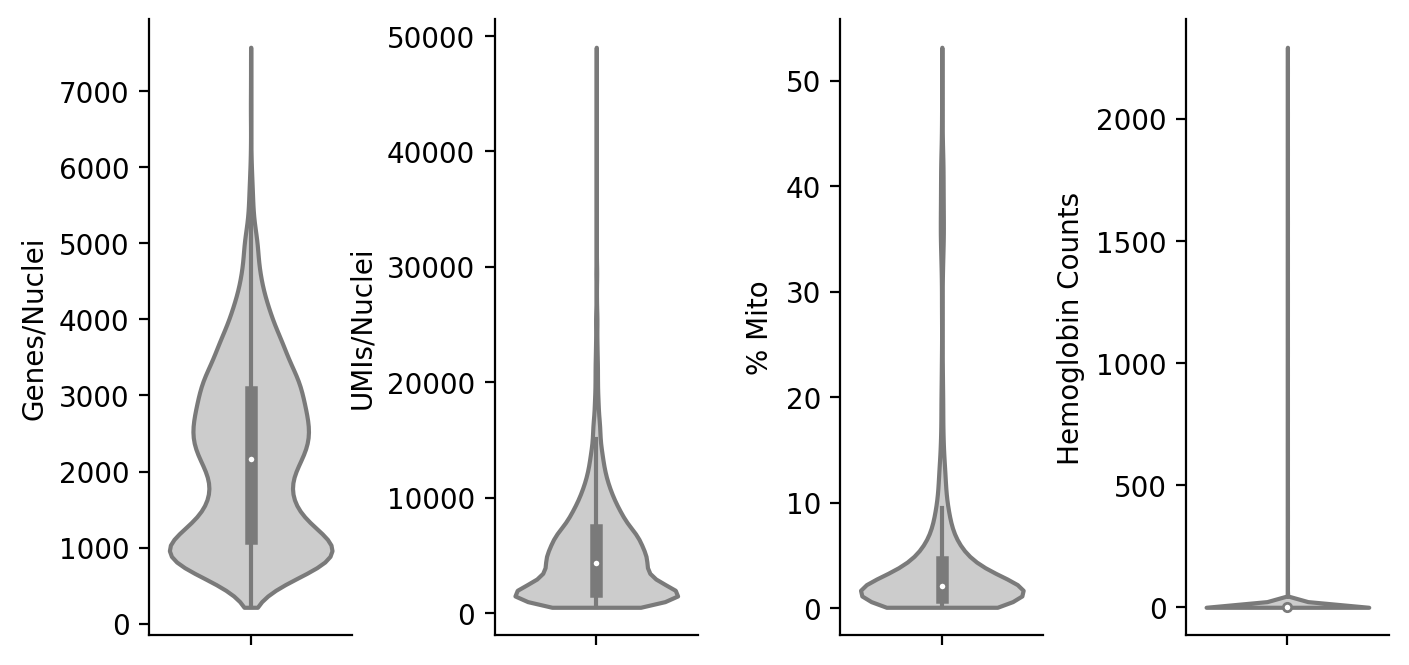

In [18]:
fig, axs = plt.subplots(1, 4, gridspec_kw=dict(wspace=0.7), figsize=(8, 4))
violin_params = dict(color="0.8", whis=[5, 95], cut=0)
sns.violinplot(data=adata.obs, y="n_genes_by_counts", ax=axs[0], **violin_params)
sns.violinplot(data=adata.obs, y="total_counts", ax=axs[1], **violin_params)
sns.violinplot(data=adata.obs, y="pct_counts_mitochondrial", ax=axs[2], **violin_params)
sns.violinplot(data=adata.obs, y="total_counts_hemoglobin", ax=axs[3], **violin_params)
[sns.despine(ax=ax) for ax in axs]
[ax.set_ylabel(lab) for ax, lab in zip(axs, ("Genes/Nuclei", "UMIs/Nuclei", "% Mito", "Hemoglobin Counts"))]

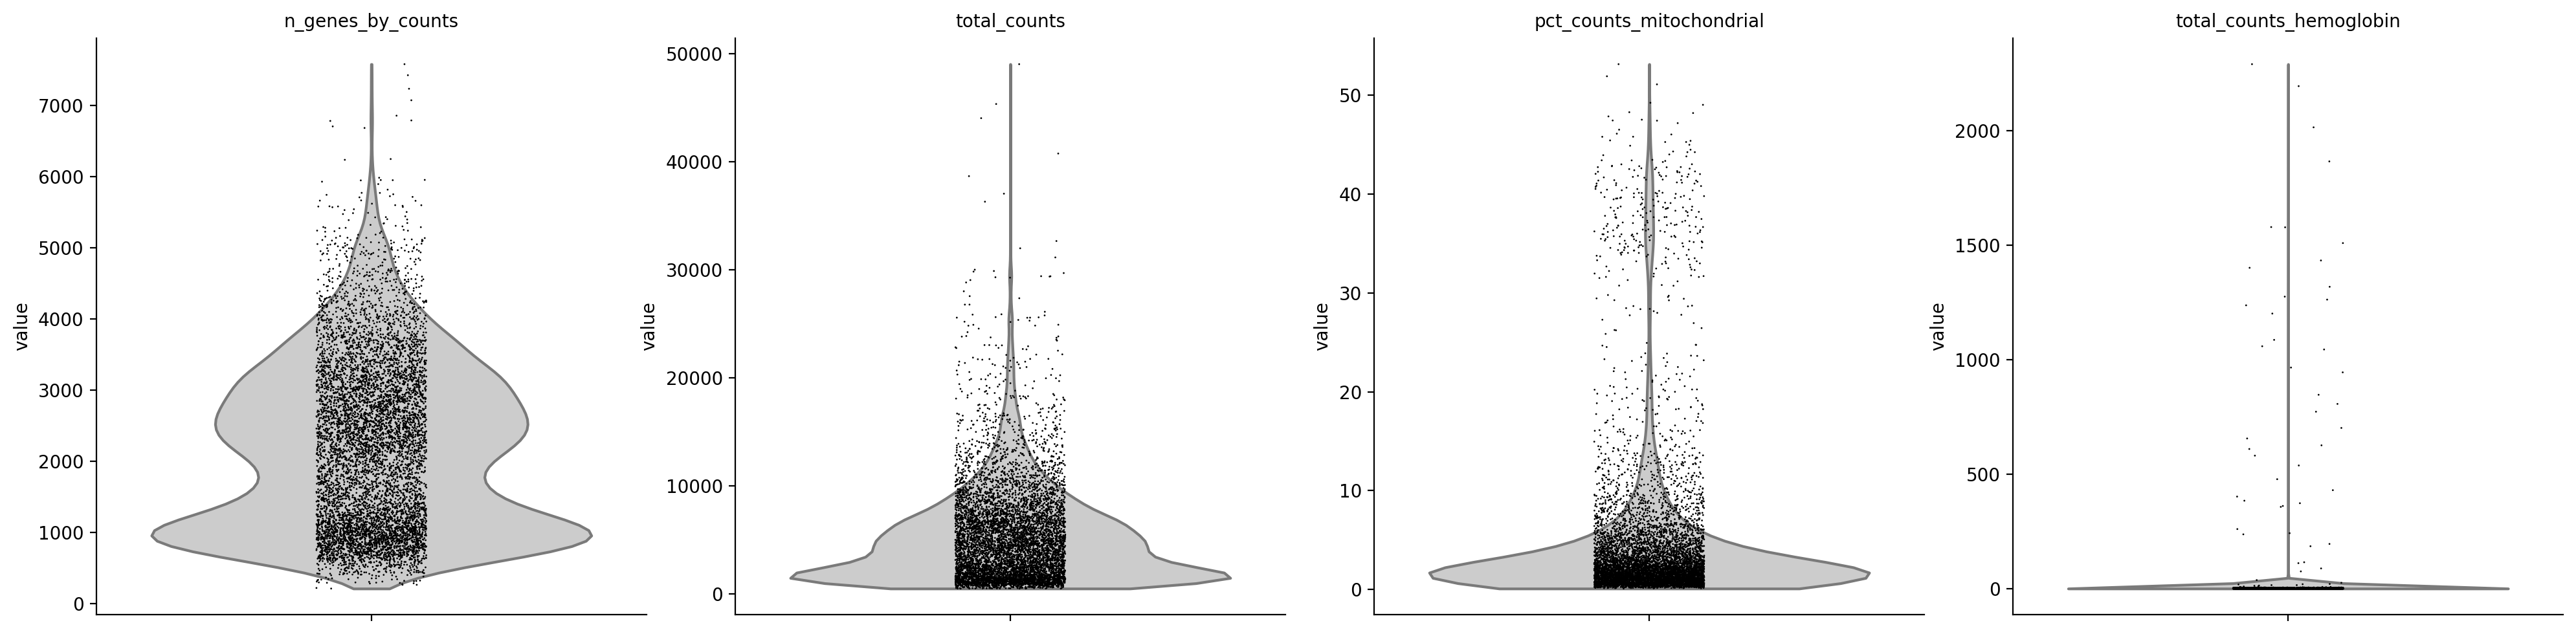

In [19]:
sc.pl.violin(
    adata, 
    ["n_genes_by_counts", "total_counts", "pct_counts_mitochondrial", "total_counts_hemoglobin"],
    multi_panel=True, stripplot=True, color="0.8"
)

## Added value by understanding the relationship between these variables

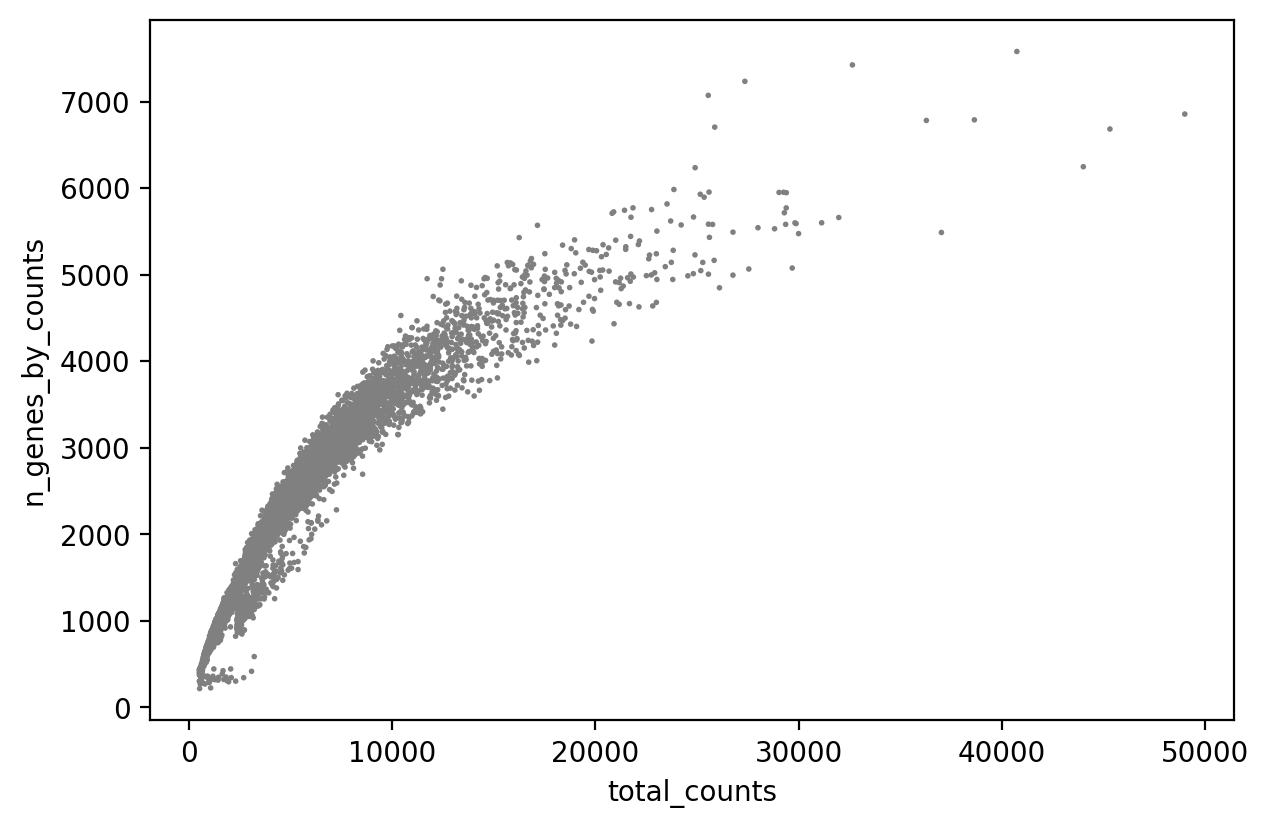

In [22]:
sc.pl.scatter(
    adata, 
    x="total_counts", 
    y="n_genes_by_counts", 
)

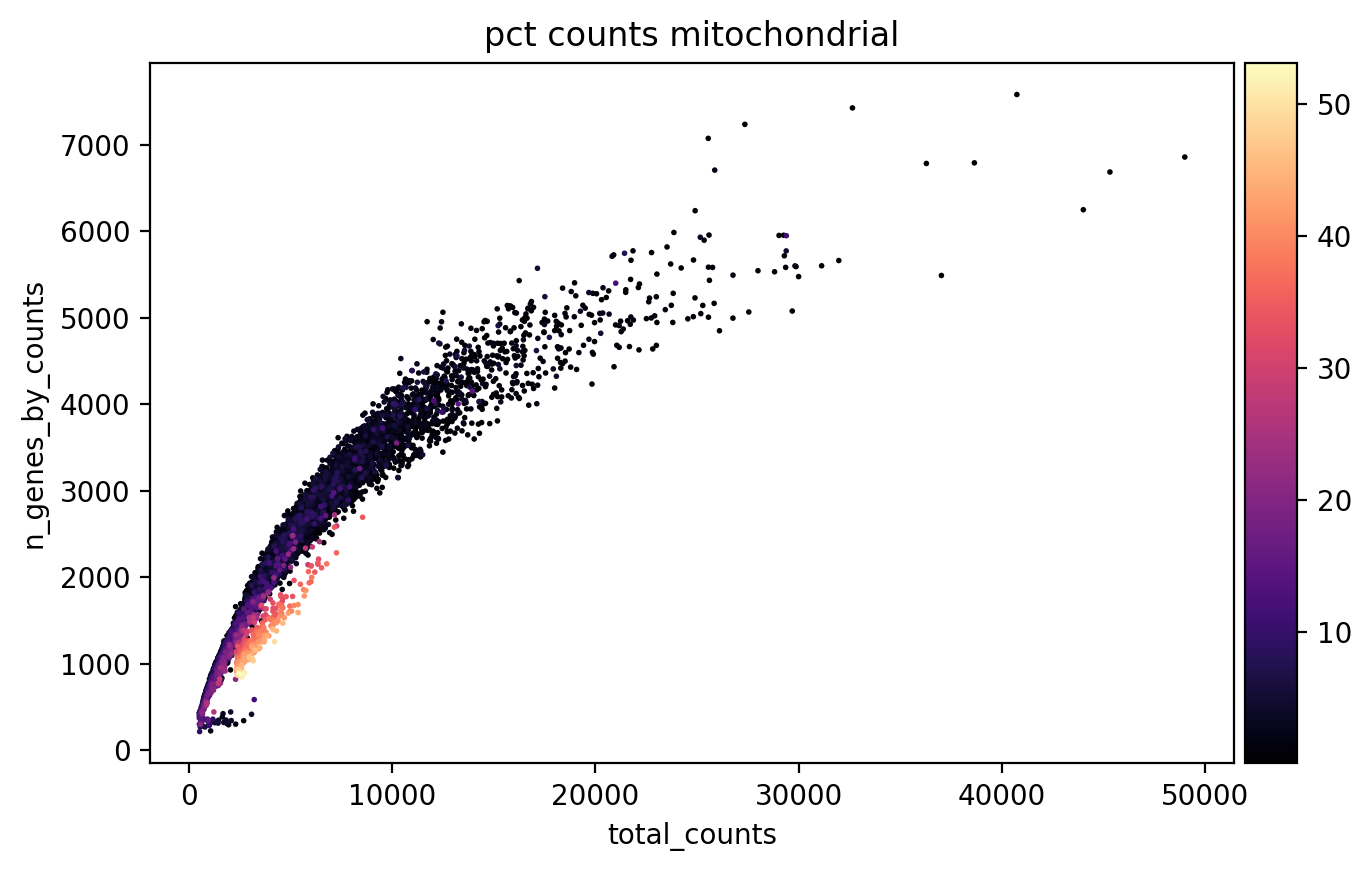

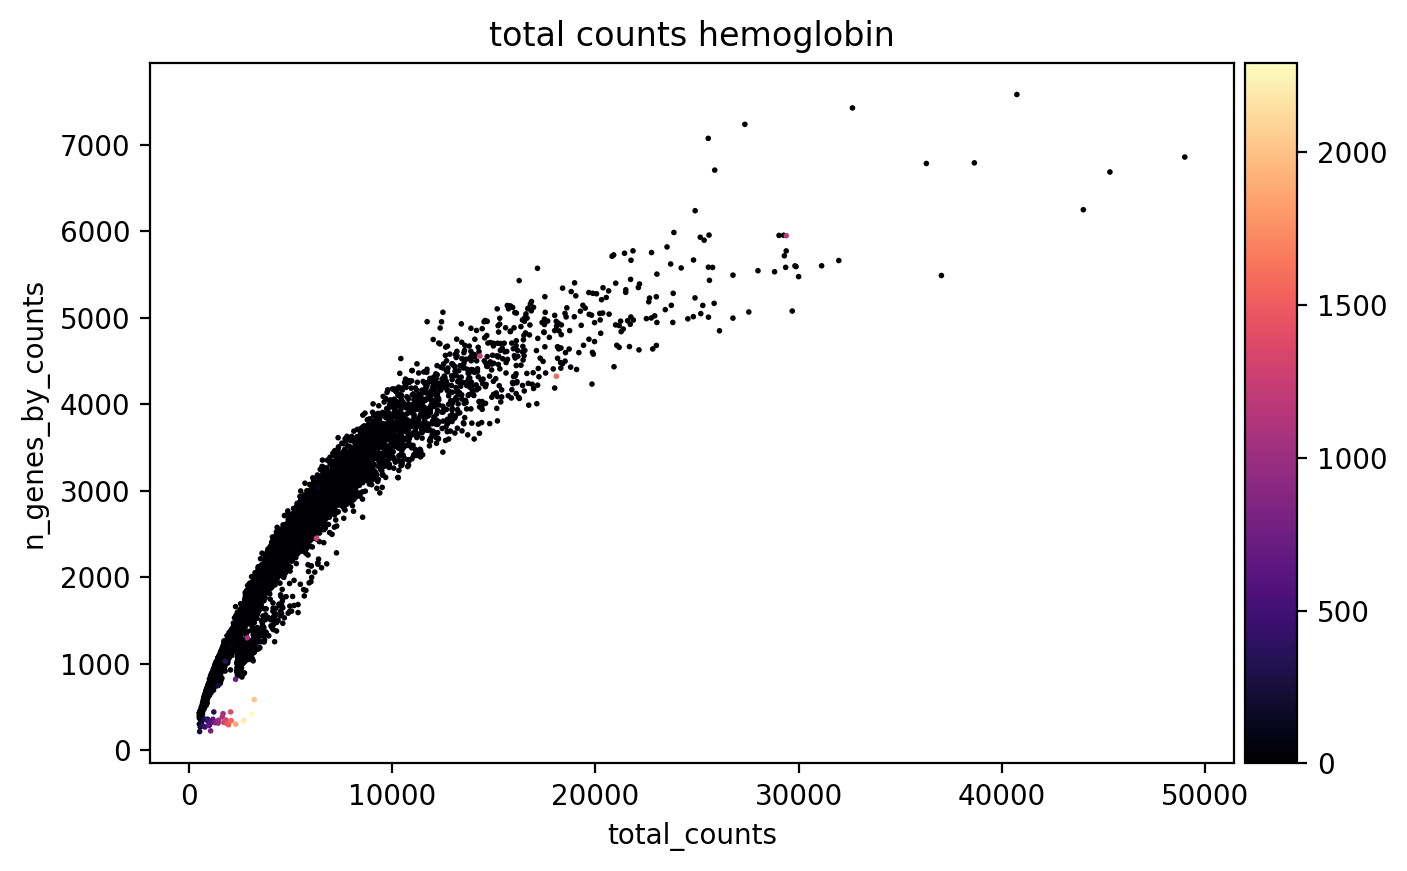

In [23]:
sc.pl.scatter(
    adata, 
    x="total_counts", 
    y="n_genes_by_counts", 
    color="pct_counts_mitochondrial",
    color_map="magma"
)

sc.pl.scatter(
    adata, 
    x="total_counts", 
    y="n_genes_by_counts", 
    color="total_counts_hemoglobin",
    color_map="magma"
)

In [24]:
sc.pp.filter_cells(adata, min_genes=1000)
keep = adata.obs.pct_counts_mitochondrial < 10
keep &= adata.obs.total_counts_hemoglobin < 20
adata = adata[keep, :].copy()

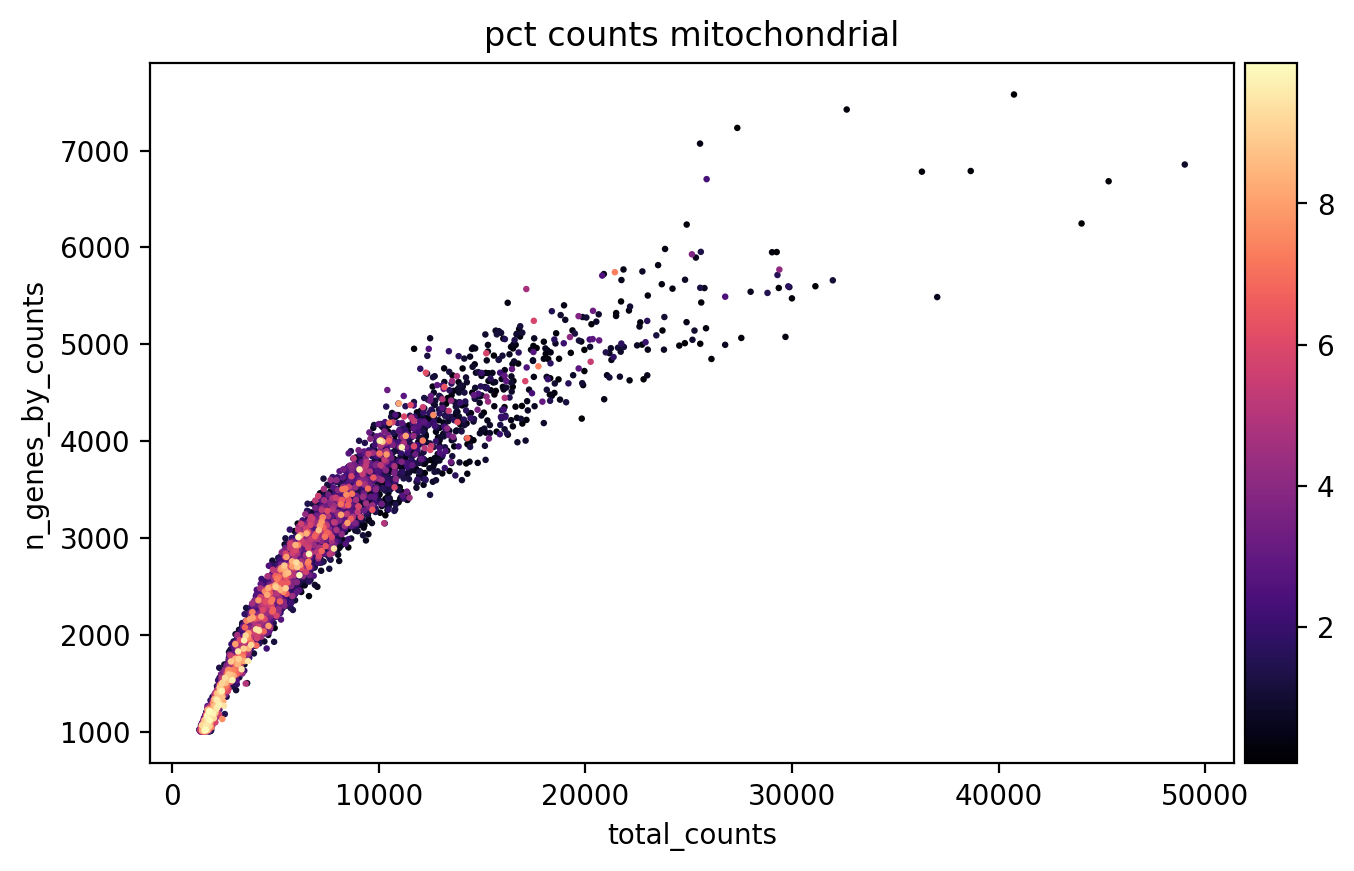

In [25]:
sc.pl.scatter(
    adata, 
    x="total_counts", 
    y="n_genes_by_counts", 
    color="pct_counts_mitochondrial",
    color_map="magma"
)


## Looking back at my arbitrary QC thresholds, what didn't I filter on?  Any guesses why?

In [26]:
sc.pp.filter_genes(adata, min_counts=10)
sc.pp.filter_genes(adata, min_cells=10)

In [27]:
adata

AnnData object with n_obs × n_vars = 5472 × 19292
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mitochondrial', 'log1p_total_counts_mitochondrial', 'pct_counts_mitochondrial', 'total_counts_ribosomal', 'log1p_total_counts_ribosomal', 'pct_counts_ribosomal', 'total_counts_hemoglobin', 'log1p_total_counts_hemoglobin', 'pct_counts_hemoglobin', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'mitochondrial', 'ribosomal', 'hemoglobin', 'exclude_from_highly_variable', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'n_cells'

## Let's clean up the data to prepare for _the most important step_

In [28]:
adata.layers["raw"] = adata.X.copy()

In [29]:
sc.pp.normalize_total(
    adata,
    target_sum=None,
    inplace=True
)
adata.layers["norm"] = adata.X.copy()

In [30]:
sc.pp.log1p(adata)

In [31]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=3000,
    flavor="cell_ranger",
)

All this did was:
- Add a column to our variable annotations denoting whether a gene is "highly variable"
- Add a few other columns like `dispersion` and `means`

In [27]:
adata.var["variance"] = np.asarray(np.var(adata.X.todense(), axis=0)).squeeze()

<AxesSubplot: xlabel='means', ylabel='dispersions_norm'>

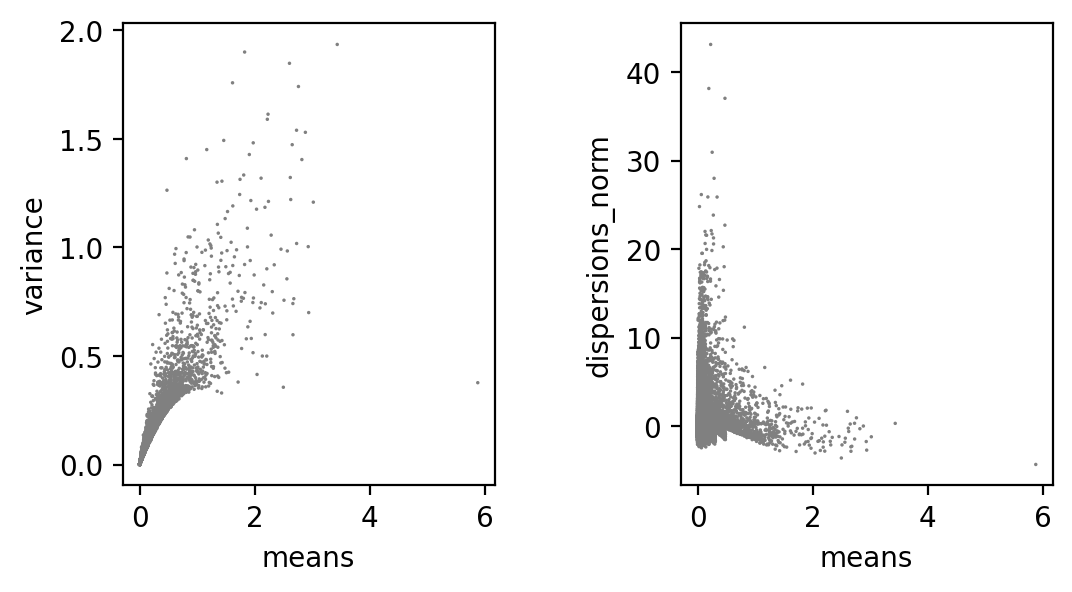

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3), gridspec_kw=dict(wspace=0.5))
sc.pl.scatter(adata, x="means", y="variance", ax=ax1, show=False)
sc.pl.scatter(adata, x="means", y="dispersions_norm", ax=ax2, show=False)

But we can also edit this highly variable gene list.  For example:

In [32]:
adata.var.groupby(["mitochondrial", "highly_variable"]).size()

mitochondrial  highly_variable
False          False              16281
               True                2998
True           False                 11
               True                   2
dtype: int64

In [33]:
adata.var.loc[["Fos", "Jun"], "highly_variable"]

Fos    False
Jun     True
Name: highly_variable, dtype: bool

In [34]:
adata.var.loc[adata.var.exclude_from_highly_variable, "highly_variable"] = False

## Proceed to Linear and manifold-based dimensionality reduction

In [35]:
sc.pp.pca(
    adata,
    use_highly_variable=True,
    n_comps=50
)

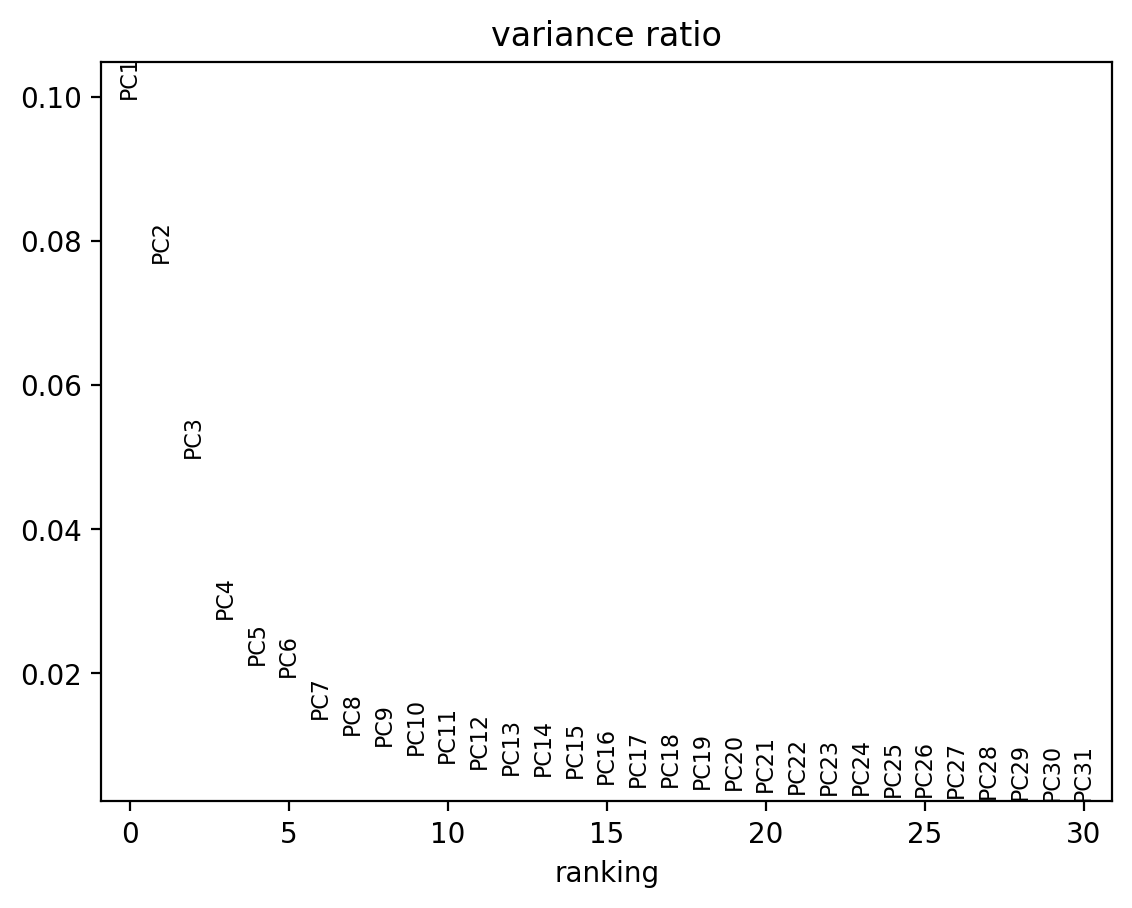

In [36]:
sc.pl.pca_variance_ratio(adata)

In [37]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=24, metric="correlation")

In [38]:
sc.tl.umap(adata, min_dist=0.5)

In [39]:
sc.tl.tsne(adata, n_pcs=24)

<AxesSubplot: xlabel='UMAP1', ylabel='UMAP2'>

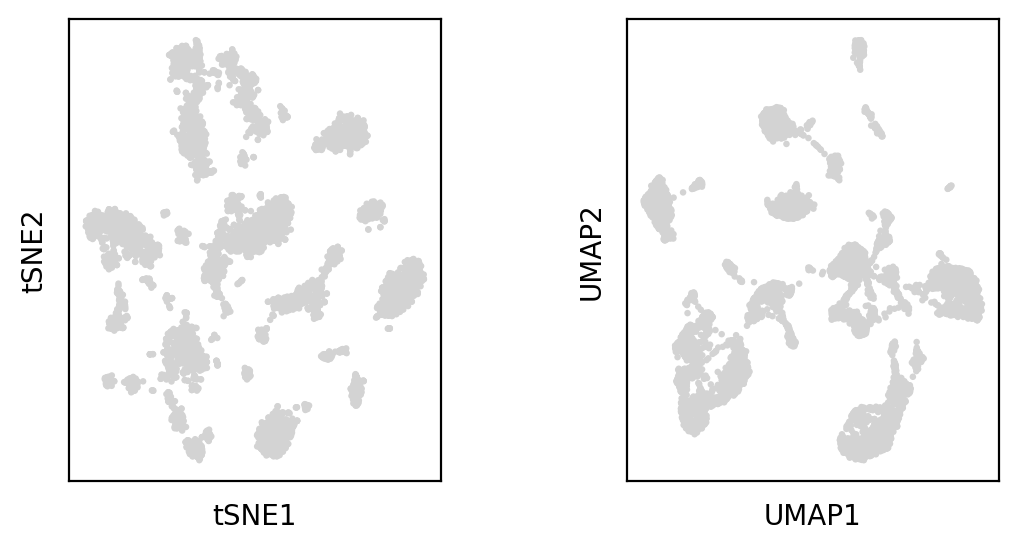

In [40]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3), gridspec_kw=dict(wspace=0.5))
sc.pl.tsne(adata, ax=ax1, show=False)
sc.pl.umap(adata, ax=ax2, show=False)

In [41]:
sc.tl.leiden(adata, resolution=1, key_added="leiden_overclustered")
sc.tl.leiden(adata, resolution=0.2, key_added="leiden_underclustered")

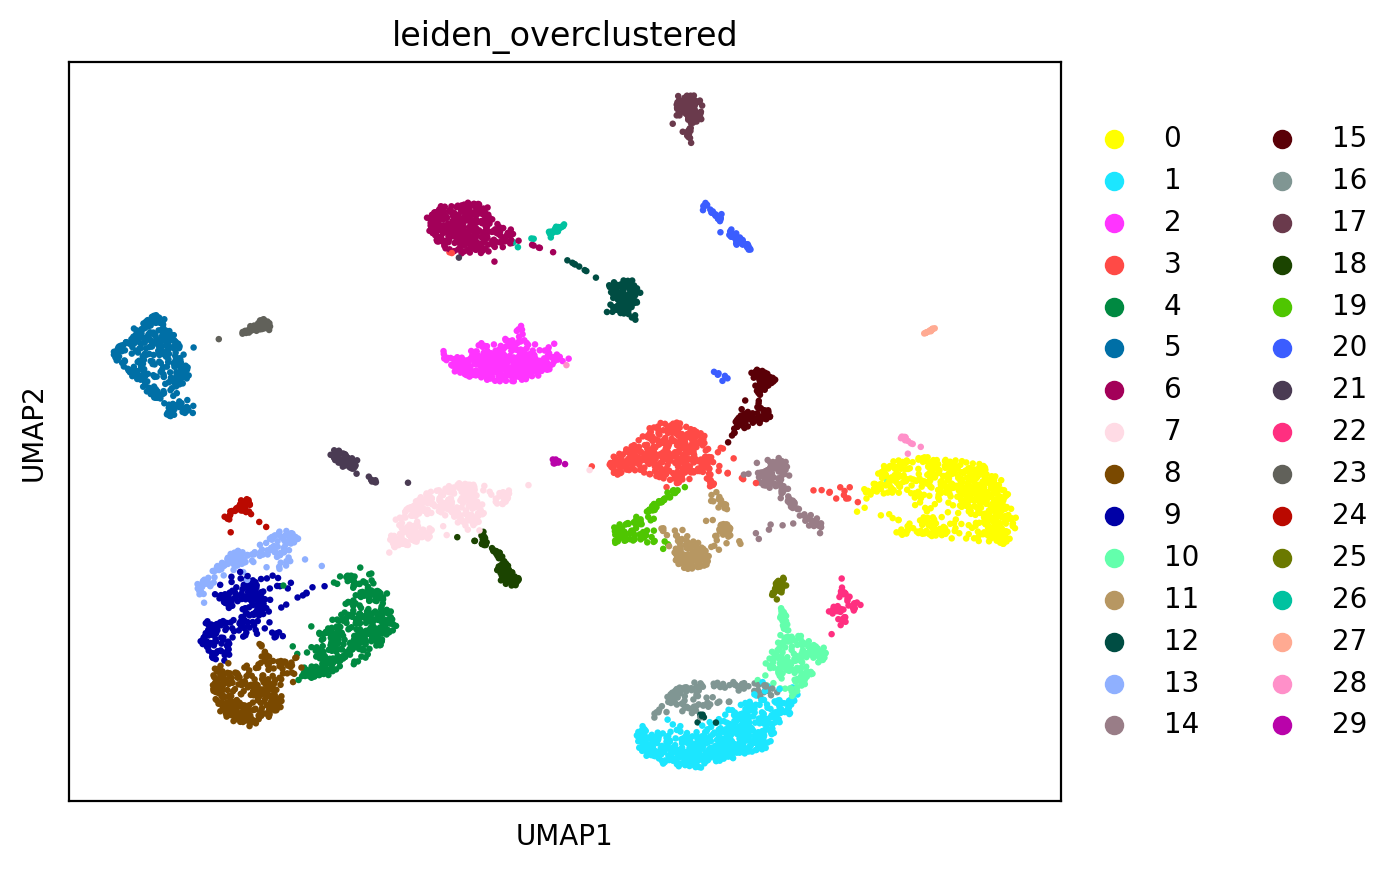

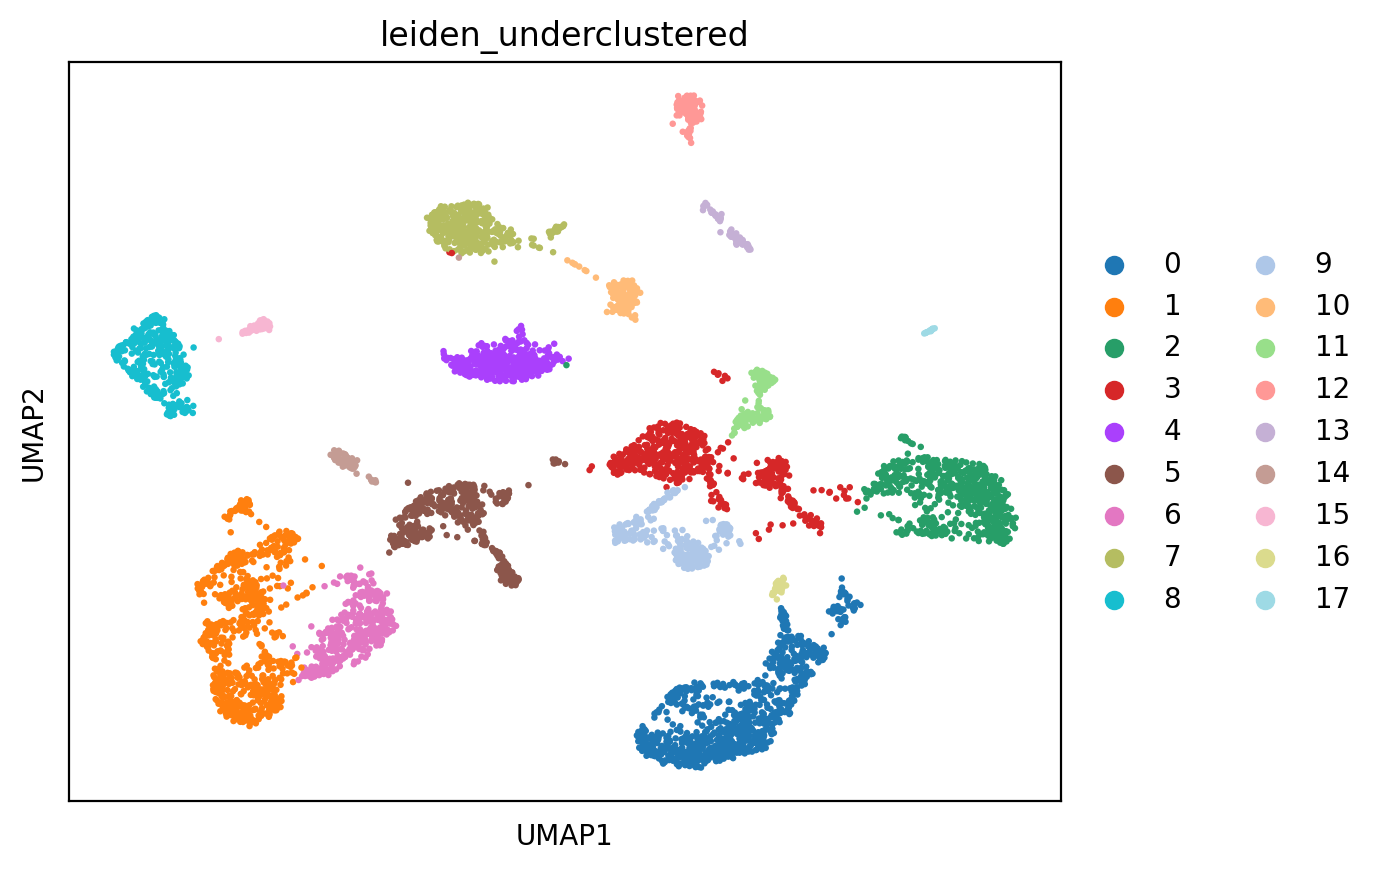

In [42]:
sc.pl.umap(adata, color="leiden_overclustered")
sc.pl.umap(adata, color="leiden_underclustered")

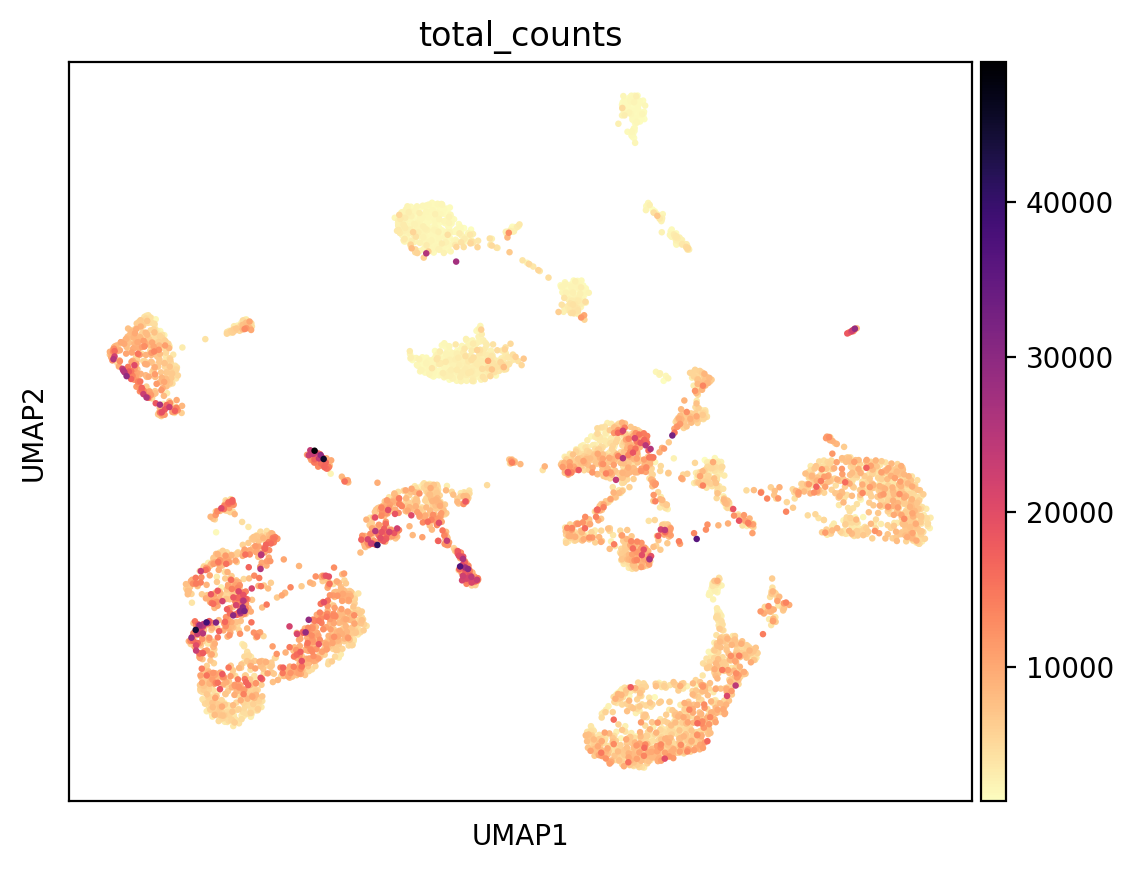

In [43]:
sc.pl.umap(adata, color="total_counts", color_map="magma_r")

### So what are these populations?

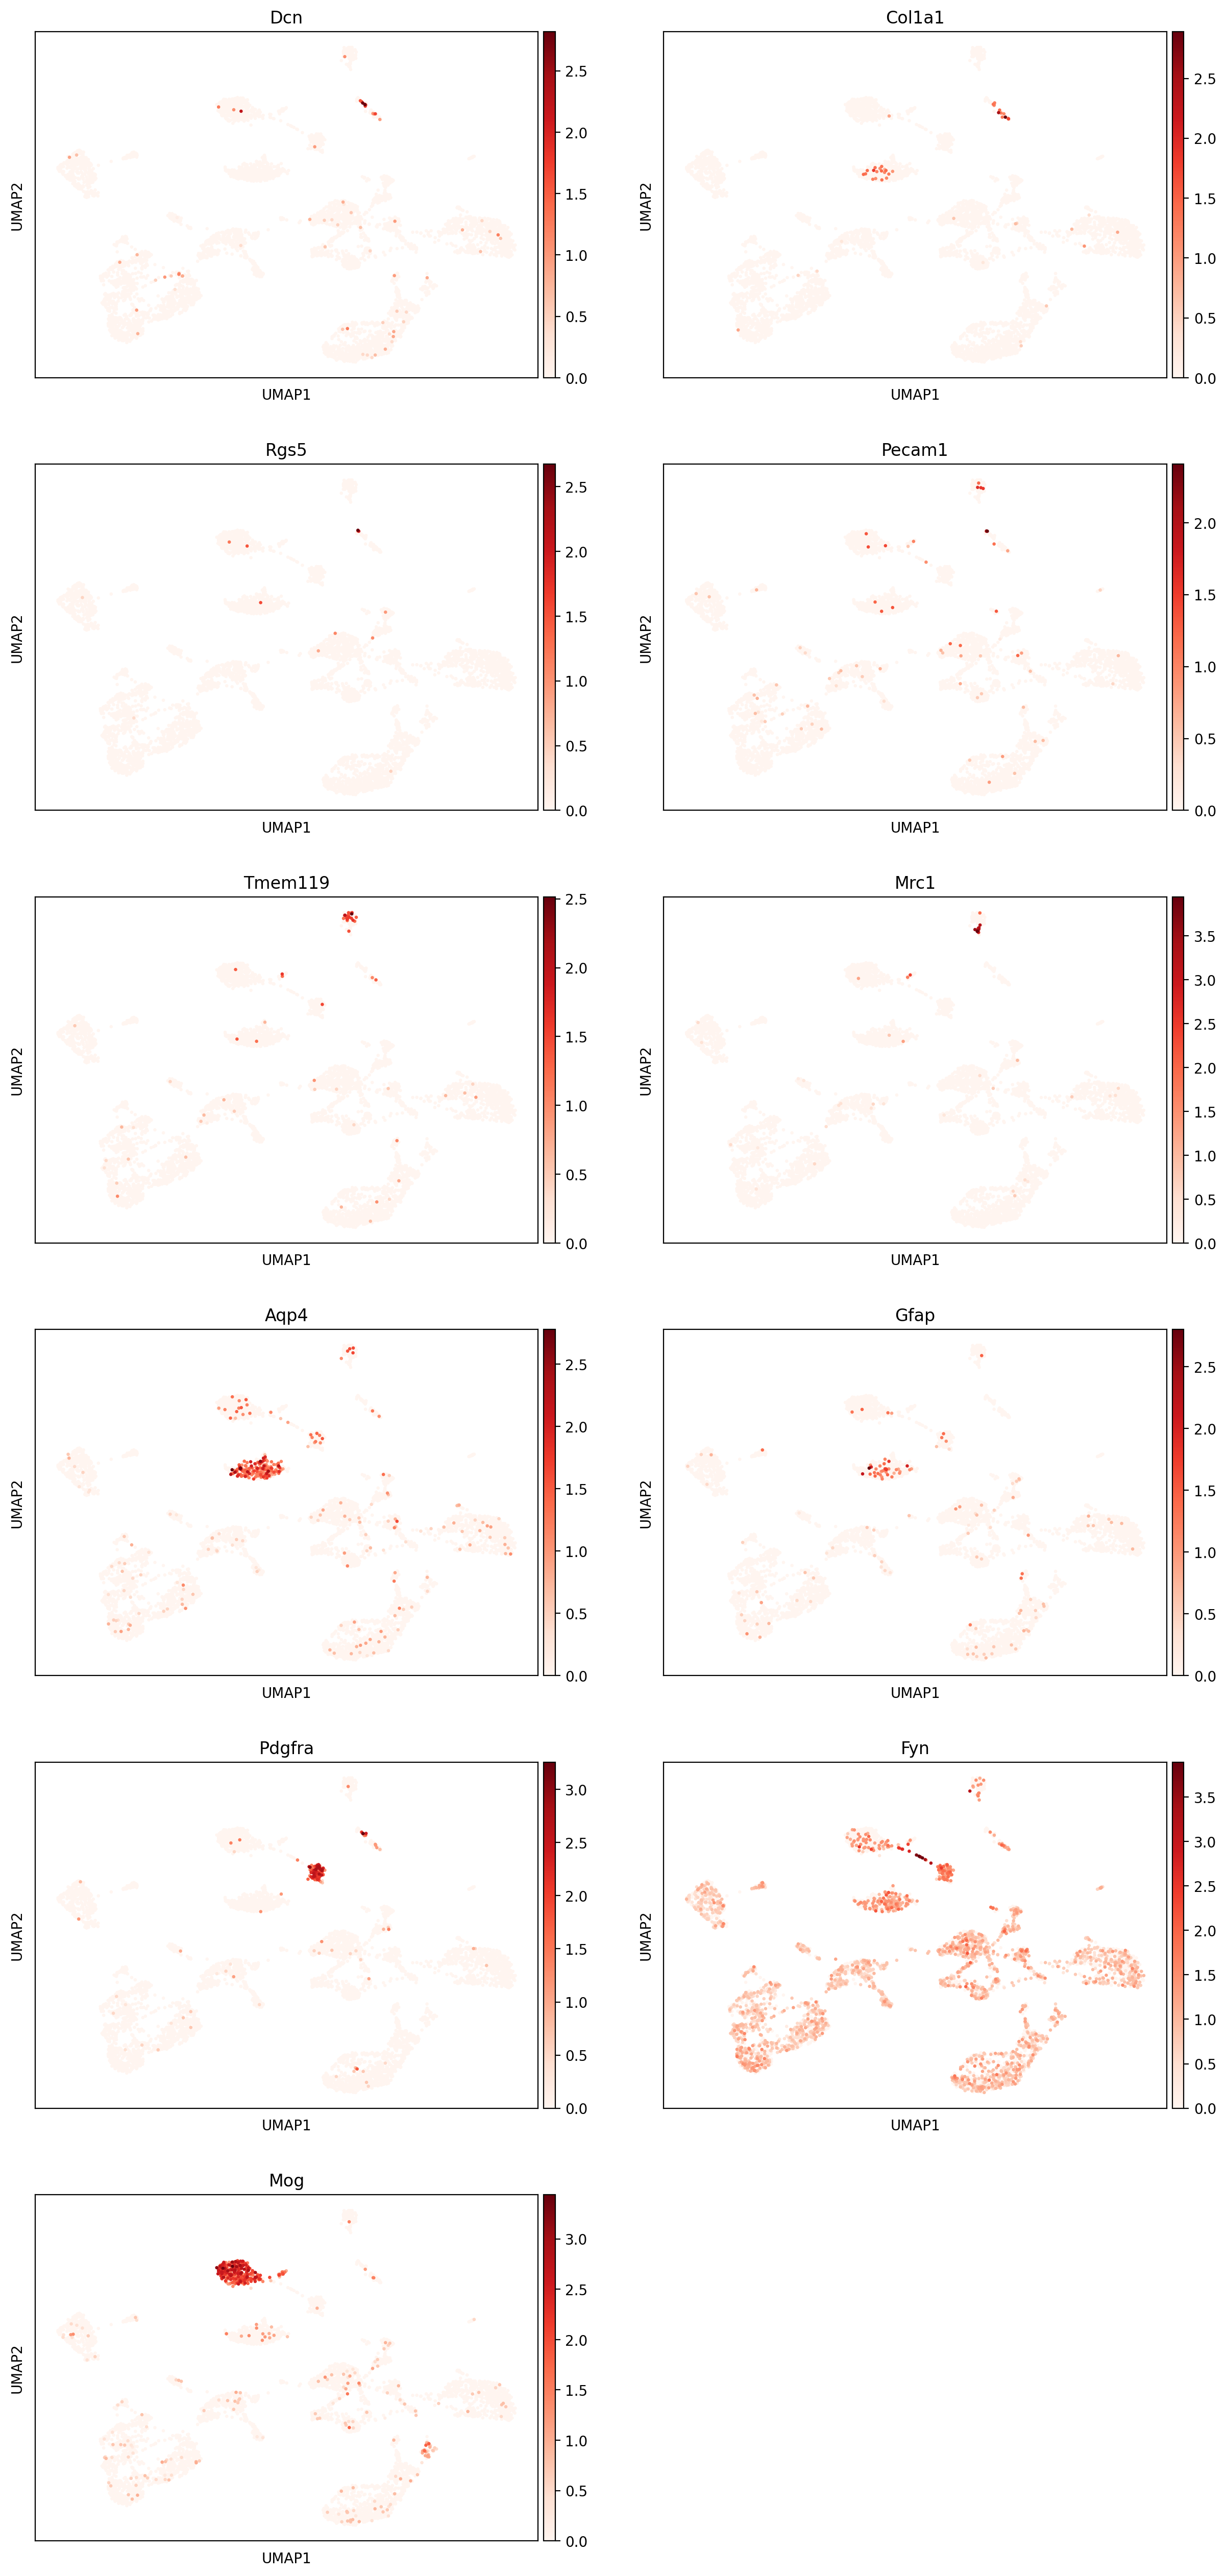

In [44]:
# Non-neuronal cell types
sc.pl.umap(
    adata, ncols=2, cmap="Reds",
    color=[
        "Dcn", "Col1a1", # "VLMCs" :(
        "Rgs5", "Pecam1", # Pericytes, Endothelial
        "Tmem119", "Mrc1", # Microglia and macrophages
        "Aqp4", "Gfap", # Astrocytes
        "Pdgfra", "Fyn", "Mog" # NG2, OPCs, Oligodendrocytes
    ]
)

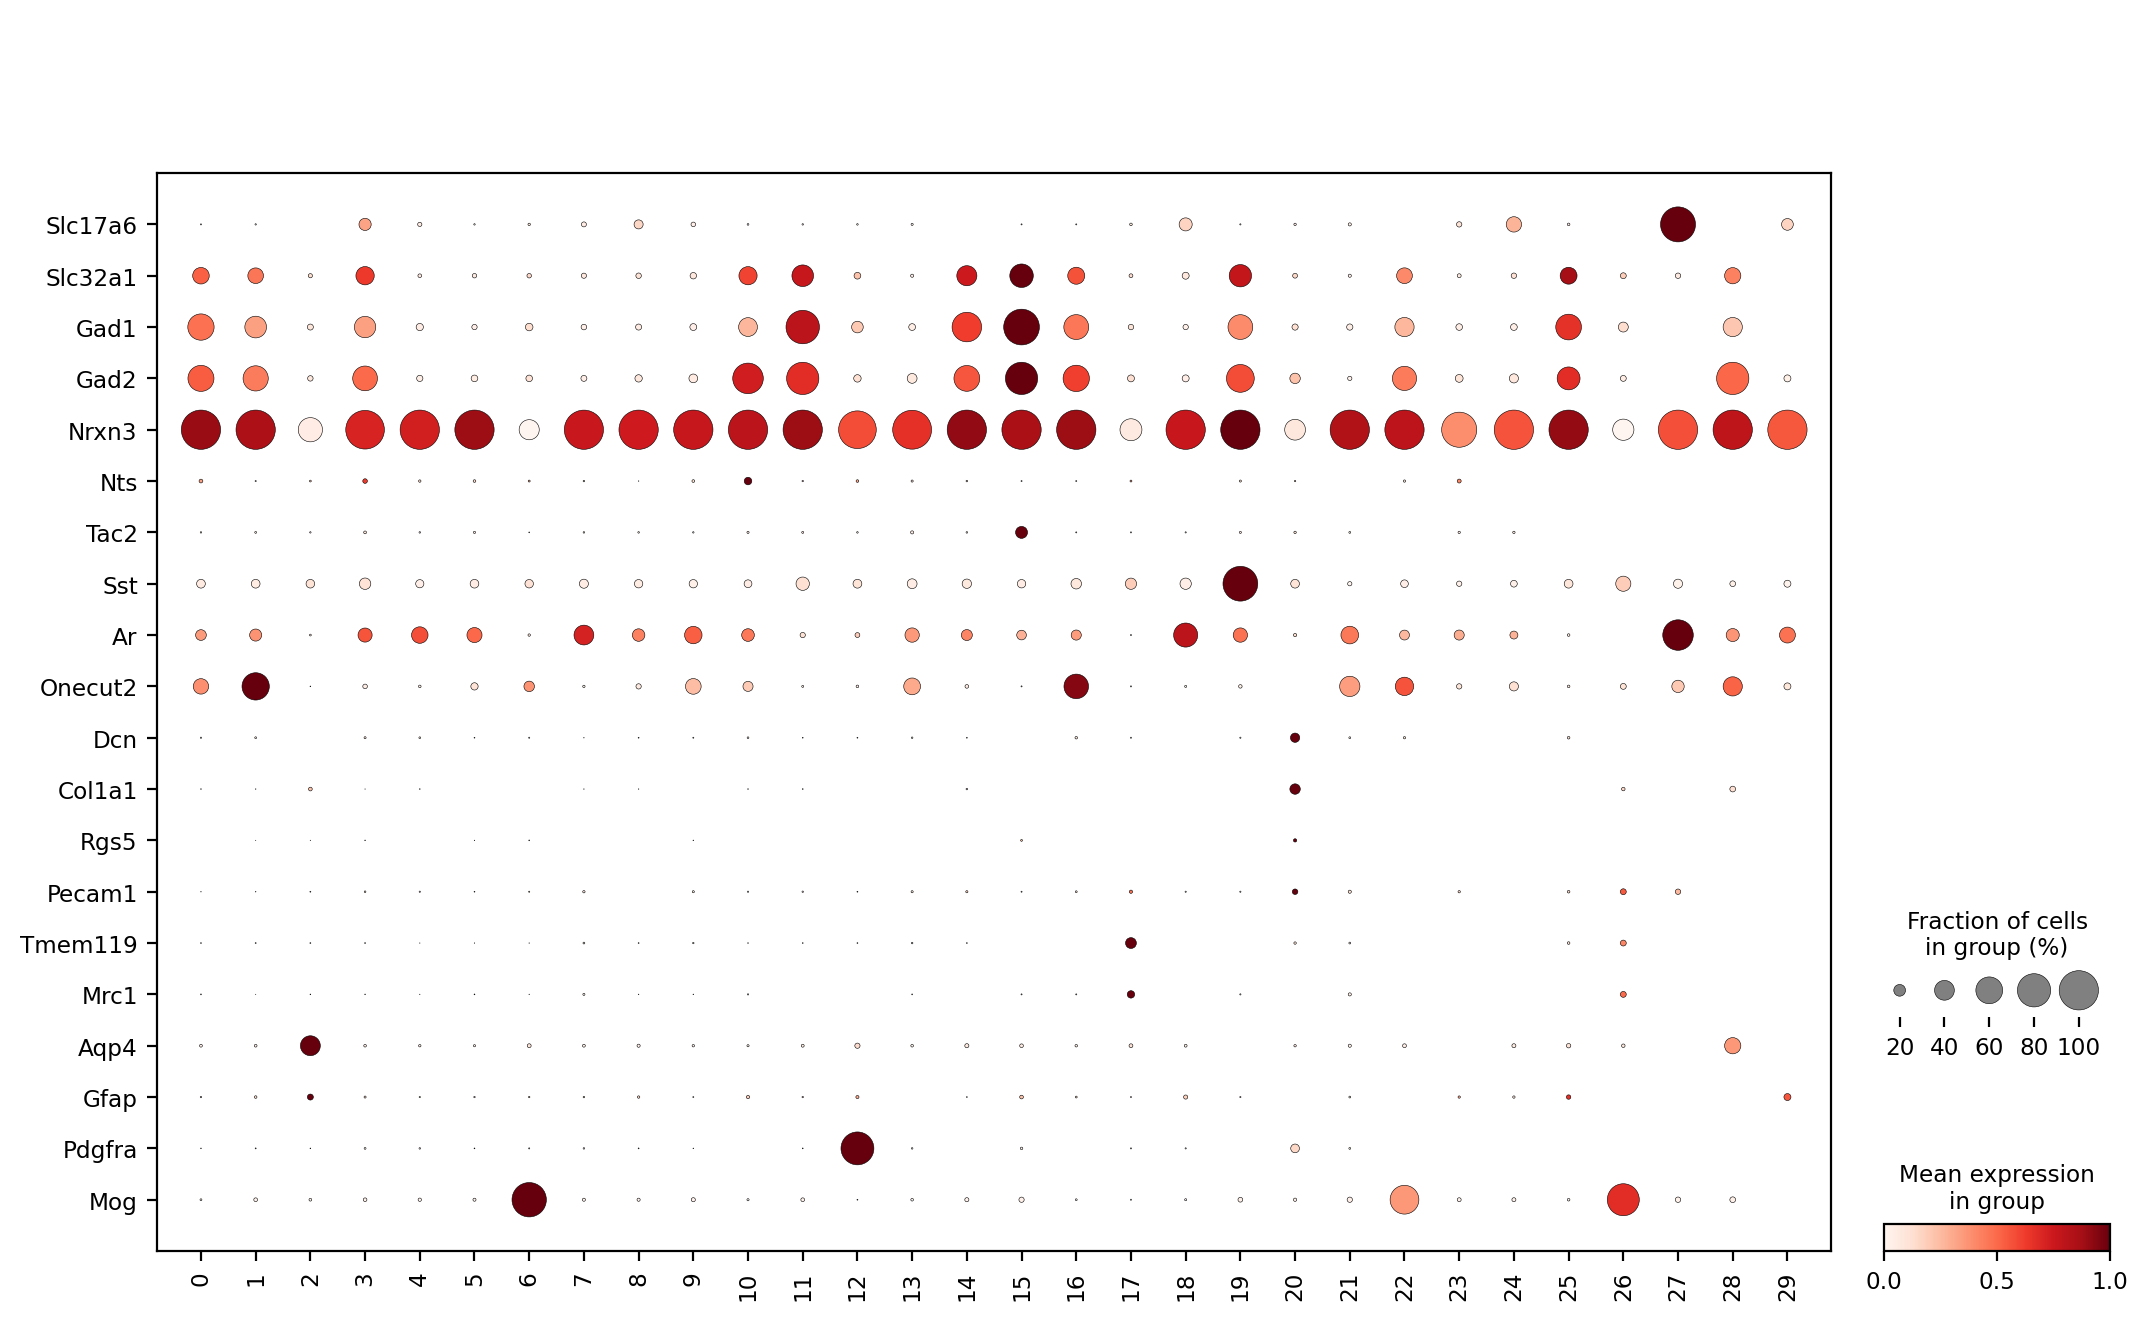

In [45]:
sc.pl.dotplot(
    adata, 
    [
        "Slc17a6", "Slc32a1", "Gad1", "Gad2",
        "Nrxn3", "Nts", "Tac2", "Sst", "Ar", "Onecut2", 
        "Dcn", "Col1a1", # "VLMCs" :(
        "Rgs5", "Pecam1", # Pericytes, Endothelial
        "Tmem119", "Mrc1", # Microglia and macrophages
        "Aqp4", "Gfap", # Astrocytes
        "Pdgfra", "Mog" # NG2, Oligodendrocytes
    ],
    groupby="leiden_overclustered",
    swap_axes=True,
    standard_scale="var"
)

## Alternatively, have the machines compute differentially expressed genes for you

In [46]:
sc.tl.rank_genes_groups(adata, groupby="leiden_overclustered", method="wilcoxon", use_raw=False)

In [47]:
sc.tl.filter_rank_genes_groups(
    adata, 
    groupby="leiden_overclustered", 
    min_in_group_fraction=0.25,
    max_out_group_fraction=0.5,
    min_fold_change=1
)

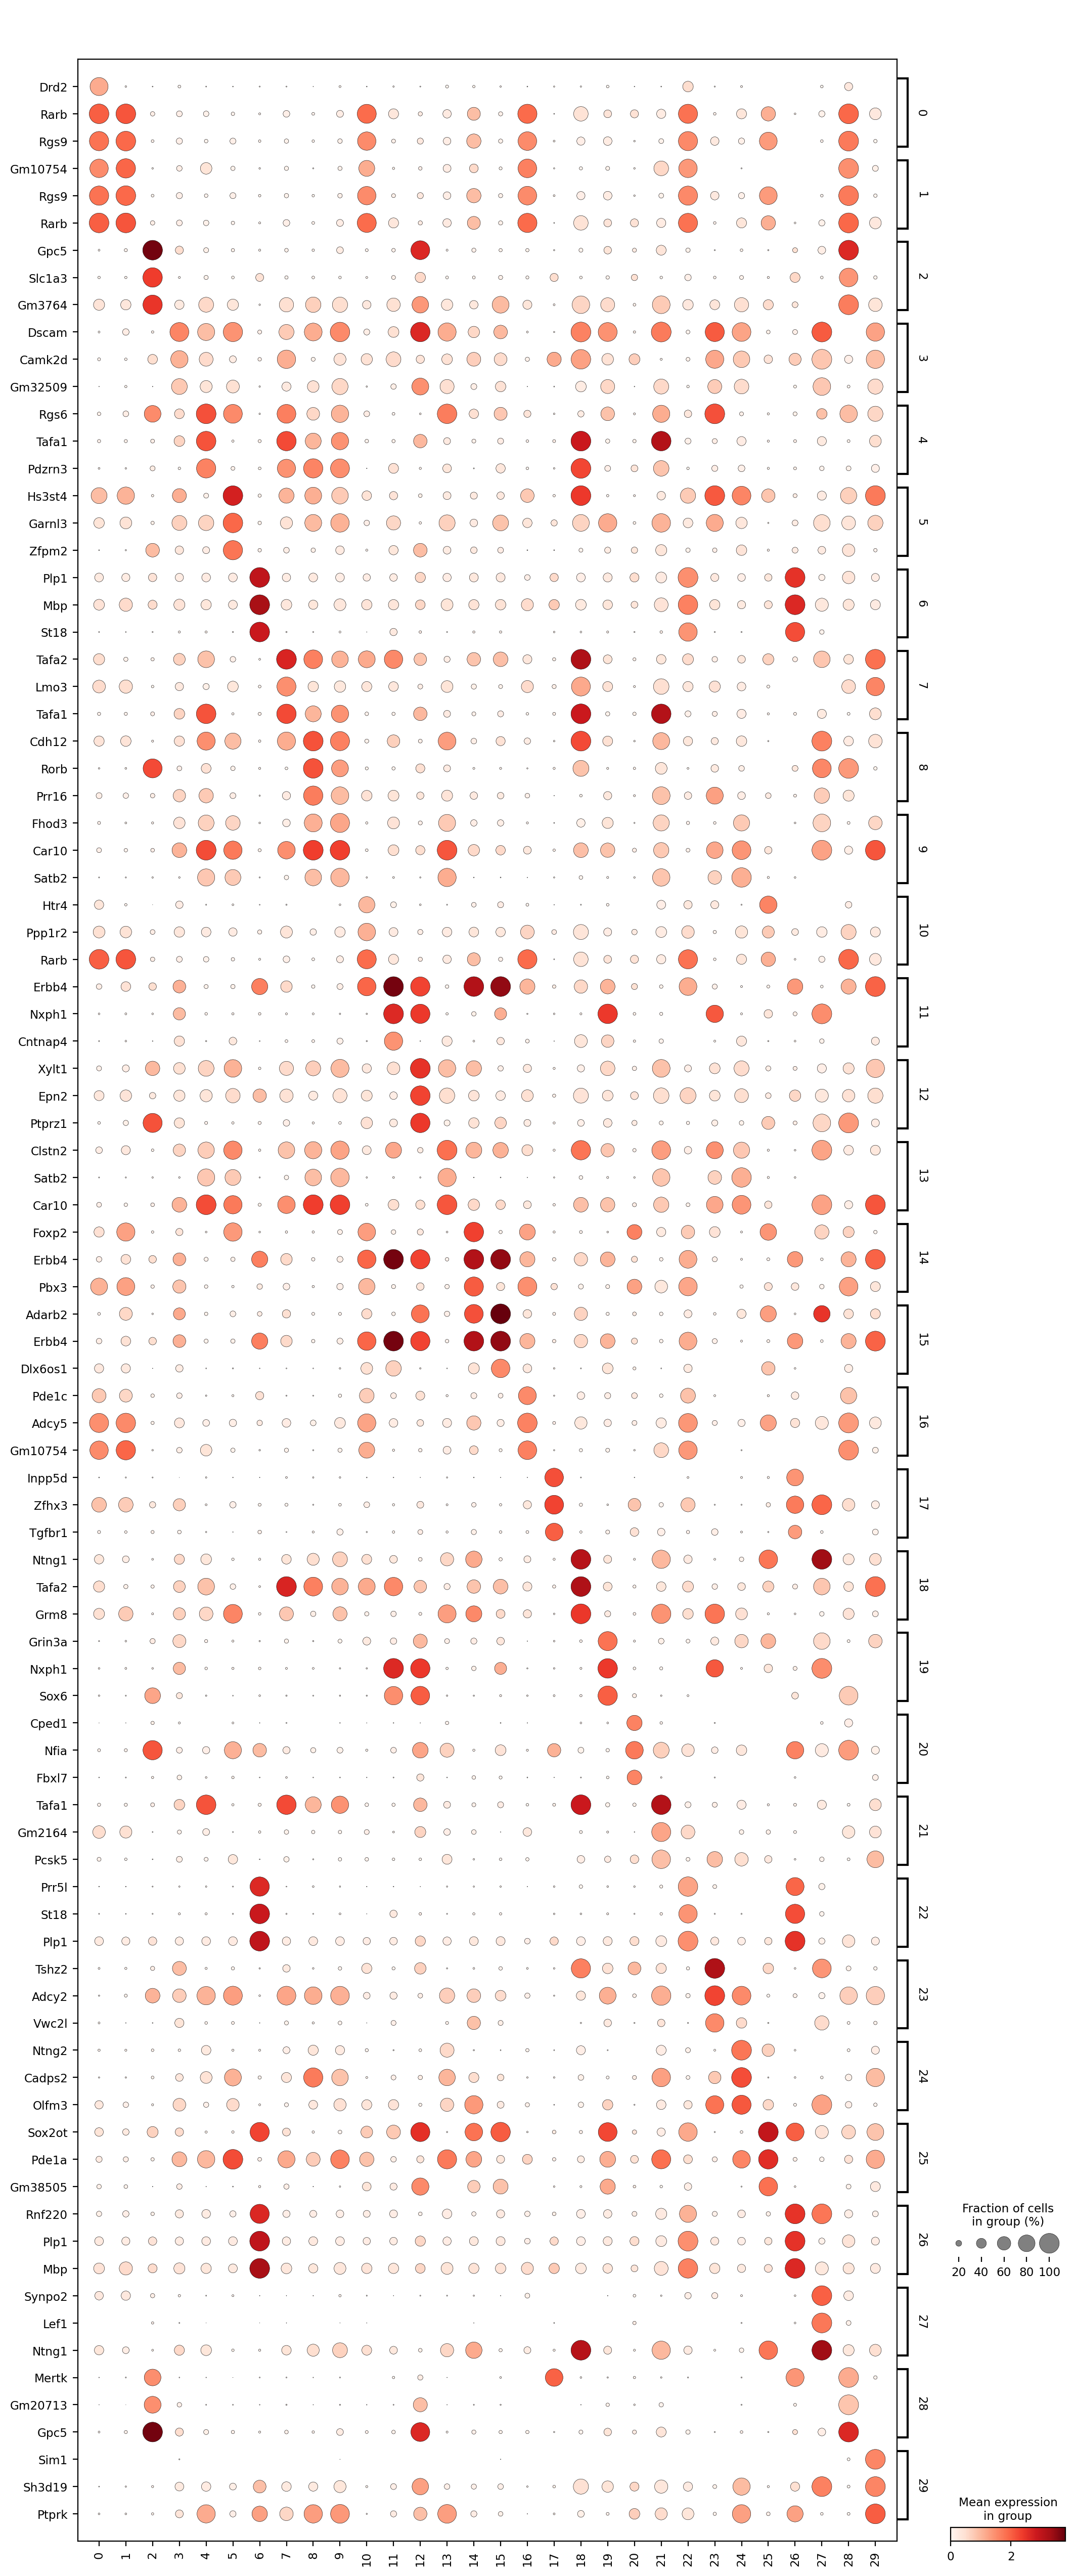

In [48]:
sc.pl.rank_genes_groups_dotplot(adata, dendrogram=False, swap_axes=True, n_genes=3, key="rank_genes_groups_filtered")

In [49]:
sc.get.rank_genes_groups_df(adata, "27").head()

names    scores  logfoldchanges         pvals     pvals_adj
0  Synpo2  6.462368        6.112750  1.030773e-10  6.828069e-07
1    Lef1  6.447800        8.558450  1.134856e-10  6.828069e-07
2   Hdac9  6.446445        4.471530  1.145045e-10  6.828069e-07
3  Kcnip4  6.391561        3.413213  1.642007e-10  6.828069e-07
4   Ntng1  6.380042        5.893076  1.770391e-10  6.828069e-07

Use these annotations to help assign (merge and annotate) clusters to cell types.  Remember, clusters are not cell types!

In [50]:
cell_type_map = {"6": "Oligodendrocyte", "26": "Oligodendrocyte", "12": "OPC", "15": "Tac2+ Neuron"}

In [51]:
adata.obs["cell_type"] = adata.obs.leiden_overclustered.map(cell_type_map)

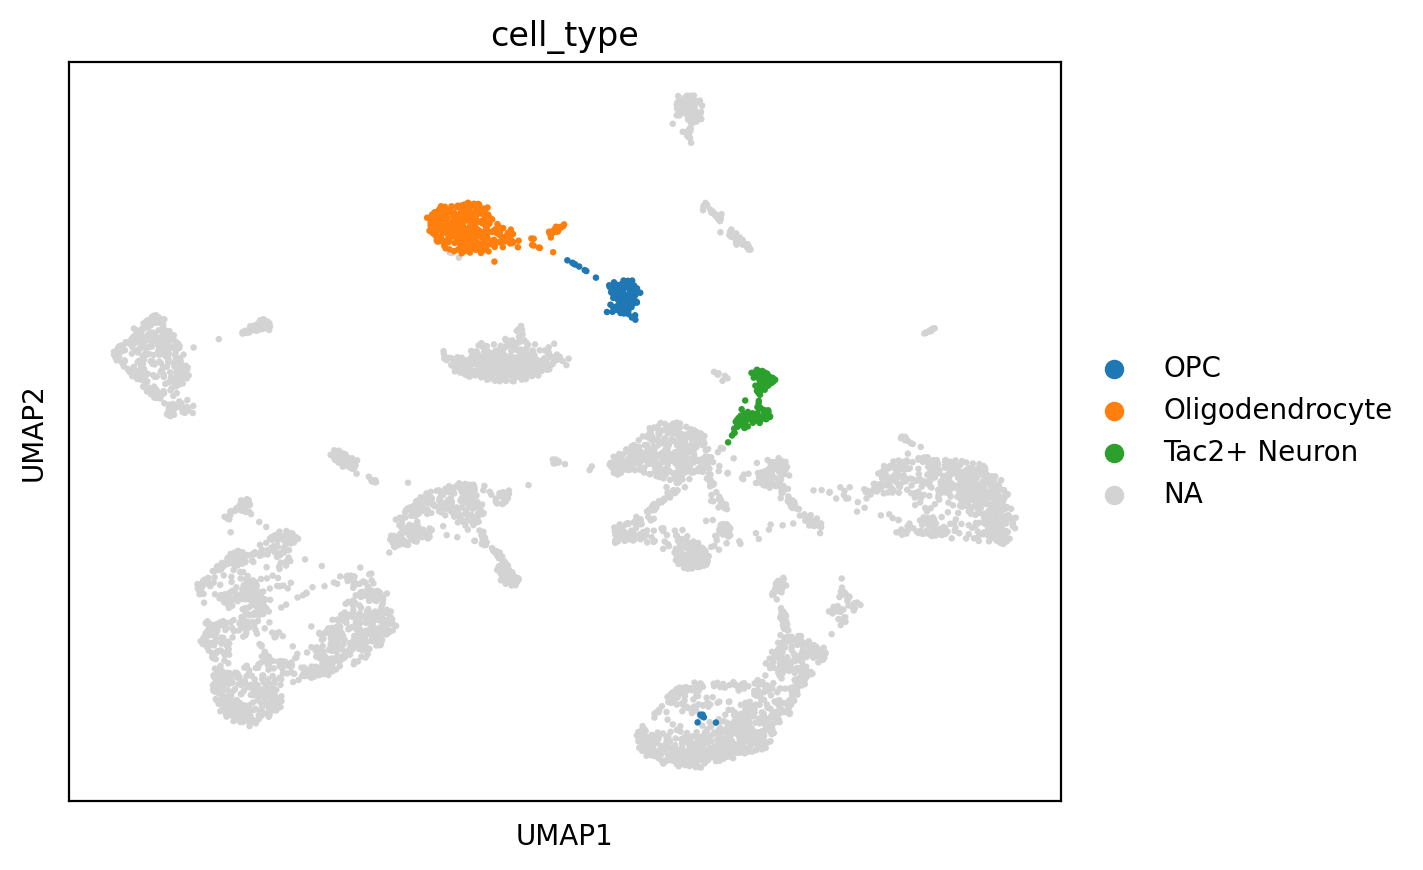

In [52]:
sc.pl.umap(adata, color="cell_type")

## Things we didn't discuss (yet)

- More stringent doublet removal
- Integration / aggregation of datasets
- Comparing and contrasting across conditions